In [14]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

In [28]:
class Squash(tf.keras.layers.Layer):

  def __init__(self):
    super(Squash,self).__init__()

  def call(self,inputs):

      v_in=tf.norm(inputs,axis=0)

      v_out=(v_in)/(v_in**2+1)

      v_out=tf.math.multiply(inputs,v_out)

      return v_out

class CapsuleModule(tf.keras.layers.Layer):

  def __init__(self,r,dc,nc):
    super(CapsuleModule,self).__init__()
    self.r=r
    self.dc=dc
    self.nc=nc

  def get_config(self):
    config=super().get_config()
    config.update({
        "r1":self.r,
        "dc1":self.dc,
        "nc1":self.nc
    })
    return config



  def build(self,input_shape):
    
    self.squash=Squash()
    self.W=self.add_weight(
        name='W1_capsule',
        shape=(input_shape[2],self.dc),
        trainable=True
    )  

  def call(self,inputs):
    
    shape=inputs.shape

    b=tf.zeros((shape[1],self.nc))

    output=list()

    u=tf.matmul(inputs,self.W)

    for j in range(self.nc):
      
      for _ in range(self.r):

        c=tf.nn.softmax(b,axis=1)
        c=tf.transpose(c)
        c_=tf.expand_dims(c[j],axis=0)
        s=tf.matmul(c_,u)
        g=self.squash(s)
        g_=tf.reshape(g,(-1,g.shape[2],g.shape[1]))
        g_=tf.matmul(u,g_)
        b+=g_
        b=b[0]

      output.append(g)

    return output
      



class Attention(tf.keras.layers.Layer):

  def __init__(self,dc,comodin):
    super(Attention,self).__init__()
    self.dc=dc
    self.comodin=comodin

  def get_config(self):
    config=super().get_config()
    config.update({
        "dc2":self.dc,
        "comodin1":self.comodin,
    })
    return config  
    
  def build(self,input_shape):

    self.squash=Squash()
    self.attention=MultiHeadAttention(5,100,100)

    self.W=self.add_weight(
        name='W1_att',
        shape=(self.comodin,self.dc),
        trainable=True
    )
    self.W2=self.add_weight(
        name='W2_att',
        shape=(self.comodin,self.dc),
        trainable=True
    )

  def call(self,inputs):

    Global_l,Vc,Vc=inputs

    Att=self.attention(Global_l,tf.matmul(Vc,self.W),tf.matmul(Vc,self.W2))
    Att=self.squash(Att)

    return Att 

class ResidualModule(tf.keras.layers.Layer):

  def __init__(self,dc,nc,do):
    super(ResidualModule,self).__init__()

    self.dc=dc
    self.nc=nc
    self.do=do

  def get_config(self):
    config=super().get_config()
    config.update({
        "dc3":self.dc,
        "nc2":self.nc,
        "do1":self.do
    })
    return config      

  def build(self,input_shape):

    self.flatten=Flatten()

    self.Wc=self.add_weight(
        name='Wc',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wl=self.add_weight(
        name='Wl',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wco=self.add_weight(
        name='Wco',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wlo=self.add_weight(
        name='Wlo',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

  def call(self,inputs):

    Global_l,Global_c,Att_l,Att_c=inputs

    Glo_c=tf.matmul(self.flatten(Global_c),self.Wc)
    Glo_l=tf.matmul(self.flatten(Global_l),self.Wl)

    Att_A=tf.nn.relu(tf.matmul(self.flatten(Att_c),self.Wco)+Glo_l)
    Att_B=tf.nn.relu(tf.matmul(self.flatten(Att_l),self.Wlo)+Glo_c)

    return Att_A,Att_B 

class encoding(tf.keras.layers.Layer):

  def __init__(self):
    super(encoding,self).__init__()

  def get_angles(self,pos, i, d_model):

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
    #return np.dot(pos,angle_rates)

  def positional_encoding(self,position, d_model):
    angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
                            
    '''Aplicando la función seno desde posición 0'''
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    '''Aplicando la función coseno desde la posición 1'''
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = angle_rads[np.newaxis, ...]
  
    return tf.cast(pos_encoding, dtype=tf.float32)
  
  def call(self,inputs):

    shape=inputs.shape

    return inputs+self.positional_encoding(shape[1],shape[2])



<font size=3>

We are going to use a pre trained embedding layer called Glove. For this, we need to use the ```tf.keras.layers.TextVectorizer``` for the preprocessing. In the files of glove, we'll find models with differents dimensions. We'll use the 300D.

 

</font>

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-18 23:29:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-18 23:29:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-18 23:29:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

<font size=5 color=orange>**Example with kaggle datasets** </font>

In [5]:
!pip install opendatasets

In [7]:
import pandas as pd
import opendatasets as od
od.download('https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis')
data=pd.read_csv('/content/imdb-movie-ratings-sentiment-analysis/movie.csv')
data=data.dropna()
data.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omleo1
Your Kaggle Key: ··········


100%|██████████| 20.6M/20.6M [00:00<00:00, 65.5MB/s]


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
def create_dataset_equality(data,key,train_size=0.8):

  '''This is for choosing proportional data'''

  classes=data[key].unique()
  train_list=[]
  test_list=[]

  for cl in classes:
    df=data[data[key]==cl]
    t_size=int(len(df)*train_size)
    df_train=df[:t_size]
    df_test=df[t_size:]

    train_list.append(df_train)
    test_list.append(df_test)

  train_df=pd.concat(train_list,axis=0)
  train_df=train_df.sample(frac=1)
  test_df=pd.concat(test_list,axis=0)  
  test_df=test_df.sample(frac=1)

  return train_df,test_df

In [9]:
train_df,test_df=create_dataset_equality(data,'label')

train_text=tf.convert_to_tensor(train_df['text'].to_list())
y_train=tf.keras.utils.to_categorical(train_df['label'].to_numpy(),num_classes=2)

test_text=tf.convert_to_tensor(test_df['text'].to_list())
y_test=tf.keras.utils.to_categorical(test_df['label'].to_numpy(),num_classes=2)

In [20]:
'''The parameters of our model'''
L=100
V=300
k=12
B=100
gru_units=B
dc=64
do=100
vocab_size=10000
nc=2 #number of classes


vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=L)
text_ds = tf.data.Dataset.from_tensor_slices(train_text).batch(128)
vectorizer.adapt(text_ds)

In [21]:
x_train=vectorizer(train_text)
x_test=vectorizer(test_text)

<font size=5 color=orange>***Creating the model***</font>

<font size=4 color=pink> ***Implementation of Glove*** </font>

In [22]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [23]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [24]:
num_tokens = len(voc) + 2
embedding_dim = V
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9702 words (298 misses)


In [29]:
def built_model(vocab_size,L,V,k,B,gru_units,dc,categories,do):

  input=Input((L))
  #Feature Extraction Module P1
  m=Embedding(num_tokens,V,input_length=L,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False)(input)
  m=encoding()(m)
  m=tf.expand_dims(m,axis=-1)
  m=Conv2D(B,
           kernel_size=(k,V),
           strides=1)(m)
  shape=m.shape
  M=tf.reshape(m,(-1,shape[1],shape[3]))         

  M=Squash()(M)

  #Feature Extraction Module P2
  
  input_lstm=tf.expand_dims(input,axis=-1)
  H=Bidirectional(GRU(gru_units,return_sequences=True))(input_lstm)
  H=Squash()(H)

  #Capsule Module
  
  Global_l=CapsuleModule(3,dc,categories)(H)#bidirectionalLSTM Global l

  Global_l=tf.concat(Global_l,axis=1)
  
  Global_c=CapsuleModule(3,dc,categories)(M)#N_gram_CNN Global c
  
  Global_c=tf.concat(Global_c,axis=1)

  #Attention module:
  
  Att_l=Attention(dc,B)((Global_l,M,M))

  Att_c=Attention(dc,2*gru_units)((Global_c,H,H))

  #Residual Module:

  Att_A,Att_B=ResidualModule(dc,categories,do)((Global_l,Global_c,Att_l,Att_c))

  V_final=tf.concat((Att_A,Att_B),axis=1)
  
  #FullyConectedLayers:
  V_final=Dropout(0.3)(V_final)
  x=Dense(200,activation='relu')(V_final)
  x=Dense(200,activation='relu')(x)
  output=Dense(categories,activation='softmax',
               kernel_regularizer=tf.keras.regularizers.L2(0.0001),
               activity_regularizer=tf.keras.regularizers.L2(0.0001))(x)
 
  model=Model(input,output)
  
  model.summary()

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(1e-3))

  return model

model=built_model(vocab_size,L,V,k,B,gru_units,dc,nc,do)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     3000600     ['input_3[0][0]']                
                                                                                                  
 encoding_2 (encoding)          (None, 100, 300)     0           ['embedding_2[0][0]']            
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 100, 300, 1)  0           ['encoding_2[0][0]']             
                                                                                              

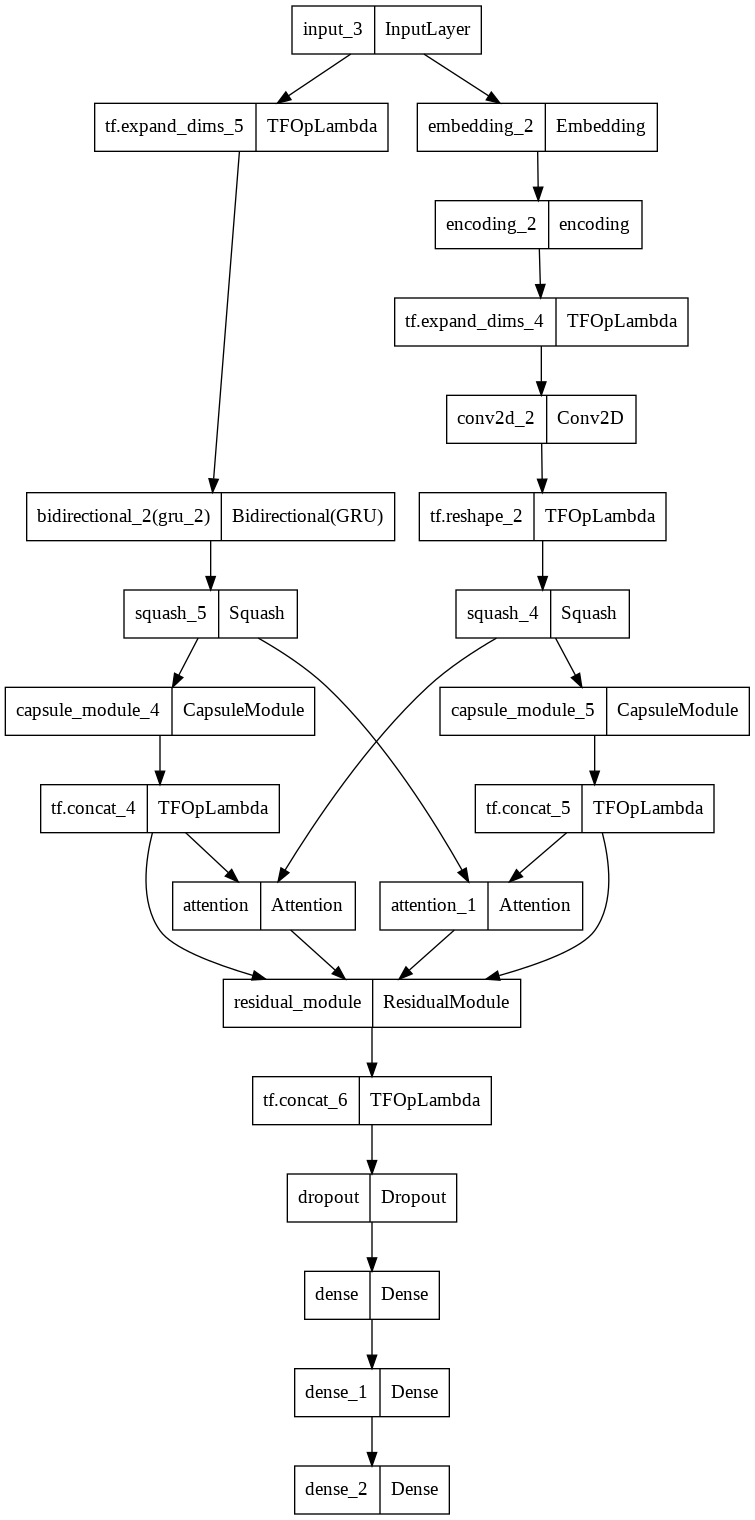

In [30]:
tf.keras.utils.plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks=[ModelCheckpoint('DGLA_model.h5',save_best_only=True)]
with tf.device('/GPU:0'):
  model.fit(x_train,y_train,validation_data=(x_test,y_test),  
            epochs=100,batch_size=32,callbacks=callbacks)